In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


(-2.521732113268817, 2.521732113268815)

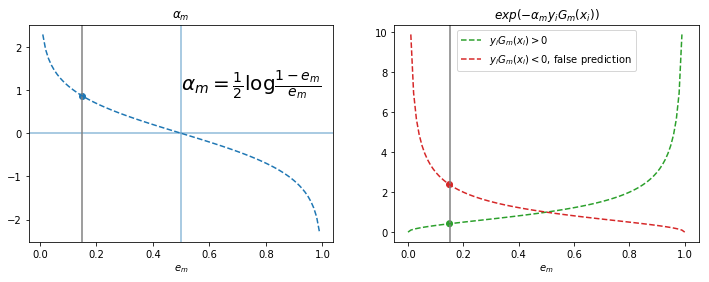

In [2]:
def alpha(error):
    return 0.5 * np.log((1 - error) / error)

e = np.linspace(0, 1, 100)
a = alpha(e)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# axs[0]  alpha_m ~ e_m -------------------------------

ALPHA_COLOR = 'C0'
axs[0].plot(e, a, linestyle='--', color=ALPHA_COLOR)

ylim0 = axs[0].get_ylim()
xlim0 = axs[0].get_xlim()

axs[0].vlines(x=0.5, ymin=ylim0[0], ymax=ylim0[1], color=ALPHA_COLOR, alpha=0.5)
axs[0].hlines(y=0, xmin=xlim0[0], xmax=xlim0[1], color=ALPHA_COLOR, alpha=0.5)
axs[0].text(0.5, 1, r'$\alpha_m = \frac{1}{2}\log\frac{1 - e_m}{e_m}$', fontsize=20)

axs[0].set_ylim(ylim0)
axs[0].set_xlim(xlim0)

axs[0].set_xlabel(r'$e_m$')
axs[0].set_title(r'$\alpha_m$')

# axs[1]  weight-update-factor `exp(-alpha * y * Gm)` ~ e_m -------------------------------

ax = axs[1]

FALSE_PREDICTION_COLOR = 'C3'
RIGHT_PREDICTION_COLOR = 'C2'

ax.plot(e, np.exp(-a), label=r'$y_i G_m(x_i) > 0$', linestyle='--', color=RIGHT_PREDICTION_COLOR)
ax.plot(e, np.exp(a), label=r'$y_i G_m(x_i) < 0$, false prediction', linestyle='--', color=FALSE_PREDICTION_COLOR)
ax.legend()
ax.set_title(r'$exp(-\alpha_m y_iG_m(x_i))$')
ax.set_xlabel(r'$e_m$')


# one example em -------------------------------

em = 0.15

ylim = ax.get_ylim()
ax.vlines(x=em, ymax=ylim[1], ymin=ylim[0], color='grey')
ax.scatter([em, em], [np.exp(-alpha(em)), np.exp(alpha(em))], color=[RIGHT_PREDICTION_COLOR, FALSE_PREDICTION_COLOR])
ax.set_ylim(ylim)


axs[0].vlines(x=em, ymin=ylim0[0], ymax=ylim0[1], color='grey')
axs[0].scatter([em], [alpha(em)], color=ALPHA_COLOR)
axs[0].set_ylim(ylim0)

## Boosting

### basic concepts

**强可学习 (strongly learnable)** 存在一个多项式学习算法能够学习它，且正确率很高  
**弱可学习 (weakly learnable)** 存在一个多项式学习算法能够学习它，正确率仅比随机猜测好

有趣的是，Schapire证明强可学习和弱可学习是等价的

那么问题就成了：如果已经发现了“弱学习算法”，能否将它提升(boost)为“强学习算法”?

1. 如何改变训练数据权值分布
2. 如何组合弱分类器

### AdaBoosting

$y \in {-1, 1} $

初始权值分布 $ w_i = \frac{1}{N} $，得到分类器 $G_0(x)$

```
for m in 1:M:
    训练分类器 G_m
    计算误差 e_m
    计算系数 \alpha_m
    调整权值 w
```

其中

1. 误差为分类错误的样本权值之和：$$e_m = \sum_i w_i I(G_m(x) \neq y_i) $$
2. 系数（弱分类器在组合成强分类器时的权重）$\alpha$ 的计算方式为 $$\alpha_m = \frac{1}{2} \log\frac{1 - e_m}{e_m}$$
3. 权值调整方式为：

$$ w_{i+1} = w_i \frac{1}{Z_m} \exp(-\alpha_m * y_i G_m(x_i)) $$

ie. 

$$ = w_i \frac{1}{Z_m} \exp(-\alpha_m),  \quad \text{样本i分类正确} $$
$$ = w_i \frac{1}{Z_m} \exp(\alpha_m),  \quad \text{样本i分类错误} $$

其中 $Z_m$ 为规范化因子

$$ Z_m = \sum_i w_i \exp(-\alpha_m * y_i G_m(x_i)) $$

最终分类器：弱分类器的线性组合

$$ f(x) = \sum_m \alpha_m G_m(x) $$
$$ G(x) = sign(f(x)) = \sum_m \alpha_m G_m(x)$$

## An 1D Example From *cise.edu.tw*

李航书中一个直观的例子

为了分段函数看起来不重叠，画图采用了手绘风格

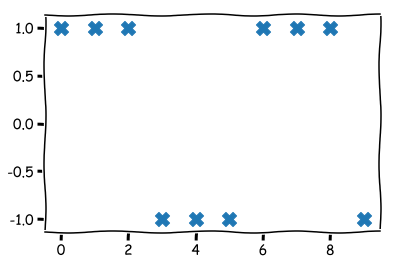

In [3]:
plt.xkcd()

x = np.arange(10)
y = np.array([1,1,1,  -1,-1,-1,  1,1,1,  -1])

fig, ax = plt.subplots()
ax.scatter(x, y, marker='X', s=200)


w1= [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

w2= [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]

w3= [0.04545455 0.04545455 0.04545455 0.16666667 0.16666667 0.16666667
 0.10606061 0.10606061 0.10606061 0.04545455] 5


Text(0.5, 1.0, 'f(x)')

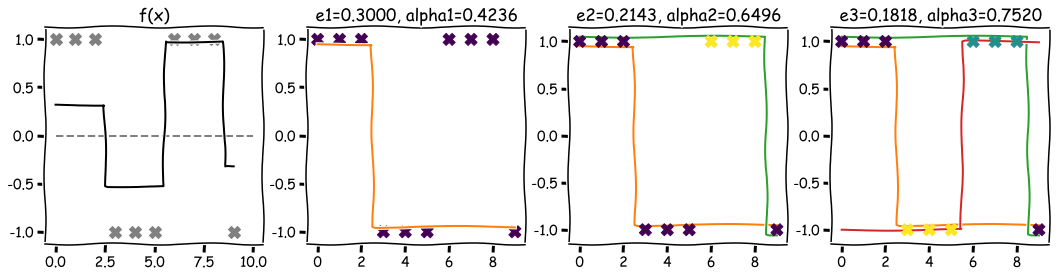

In [14]:
def G_Factory(threshold, reverse=1):
    assert reverse in (-1, 1)
    def G(x):
        return ((x > threshold).astype(int) - 0.5) * 2 * reverse
    return G

def error(y, y_hat, w):
    return np.sum((y != y_hat) * w)

def alpha(error):
    return 0.5 * np.log((1 - error) / error)  # log(odds)

def _to_weight(w):
    assert (w >= 0).all()
    return w / np.sum(w)

def updated_w(w, alpha, y, yhat):
    adjust_factor_v = np.exp(-alpha * y * yhat)
    return _to_weight(w * adjust_factor_v)


# 画图 ------------------------------------------

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
mpl.rcParams['scatter.marker'] = 'X'
mpl.rcParams['lines.markersize'] = 12
# mpl.rcParams['image.cmap'] = mpl.cm.RdYlGn


dense_x = np.linspace(0, 9, 100)  # 画图用，更密集的x
axs[0].scatter(x, y, color='grey')


# 初始化权值 ------------------
N = 10
w1 = np.repeat(1 / N, N)

# 第一轮 ----------------------
print('\nw1=', w1)

G1 = G_Factory(2.5, -1)  # 根据 G(.) 的具体形式，有不同的实现，这里直接给结果
y1 = G1(x)
e1 = error(y, y1, w1)
alpha1 = alpha(e1)

axs[1].scatter(x, y, c=w1)
axs[1].plot(dense_x, G1(dense_x) * 0.95, color='C1')  # 调整y，避免线条重合
axs[1].set_title('e1={:.4f}, alpha1={:.4f}'.format(e1, alpha1))

w2 = updated_w(w1, alpha1, y, y1)

# 第二轮 ----------------------
print('\nw2=', w2)

G2 = G_Factory(8.5, -1)
y2 = G2(x)
e2 = error(y, y2, w2)
alpha2 = alpha(e2)

_ = axs[2].scatter(x, y, c=w2, zorder=100)
axs[2].plot(dense_x, G1(dense_x) * 0.95, color='C1')
axs[2].plot(dense_x, G2(dense_x) * 1.05, color='C2')
axs[2].set_title('e2={:.4f}, alpha2={:.4f}'.format(e2, alpha2))

w3 = updated_w(w2, alpha2, y, y2)

# 第三轮 ----------------------
print('\nw3=', w3, 5)

G3 = G_Factory(5.5, 1)
y3 = G3(x)
e3 = error(y, y3, w3)
alpha3 = alpha(e3)

axs[3].scatter(x, y, c=w3, zorder=100)
axs[3].plot(dense_x, G1(dense_x) * 0.95, color='C1')
axs[3].plot(dense_x, G2(dense_x) * 1.05, color='C2')
axs[3].plot(dense_x, G3(dense_x), color='C3')
axs[3].set_title('e3={:.4f}, alpha3={:.4f}'.format(e3, alpha3))

# 组合成强分类器 ----------------------

def f(x):
    return alpha1 * G1(x) + alpha2 * G2(x) + alpha3 * G3(x)

def G(x):
    return np.sign(f(x))

axs[0].plot(dense_x, f(dense_x), color='k')
axs[0].hlines(y=0, xmin=0, xmax=10, color='grey', linestyle='--')
#axs[0].plot(dense_x, G(dense_x))
axs[0].set_title('f(x)')
